#**Introduction**
In the modern era, air quality has become an increasing concern for public health and the environment. Atmospheric pollution, resulting from various human activities and natural phenomena, affects the respiratory and cardiovascular health of millions of people and contributes to global climate change. In this context, the ability to accurately predict pollution levels is a vital tool for making informed decisions and implementing effective policies.

This project focuses on the application of Long Short-Term Memory (LSTM) neural networks for predicting air pollution, using temperature, pressure, dew point, wind speed, snow, and rain as covariates. Additionally, the technique of permuted feature importances (PFI) is employed to evaluate the relevance of each of these covariates in the predictive model. By combining the power of LSTM with feature importance analysis, this approach not only improves prediction accuracy but also provides valuable insights into the factors that most influence pollution levels.

The objective of this sample project is to develop a multivariate unistep model (a predicted value for the target variable based on the information provided by each dataset consisting of the target variable and its covariates) for the variable "pollution" and use the PFI technique to reveal which features have the most weight in the dataset.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import datetime as dt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import RMSprop
import warnings
warnings.filterwarnings("ignore")

#**Exploratory Analysis**
In this first section, the focus is on verifying and adjusting the temporal resolution, visualizing and identifying seasonality in the target variable (if it exists), and its trend.

In [4]:
raw_df = pd.read_csv("LSTM-Multivariate_pollution.csv")
raw_df.head()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [5]:
print(raw_df["pollution"].min())
print(raw_df["pollution"].max())

0.0
994.0


In [6]:
#Adjusting the "date" variable to datetime data type and formatting it accordingly.
raw_df["date"] = pd.to_datetime(raw_df["date"], format="%Y-%m-%d %H:%M:%S")
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       43800 non-null  datetime64[ns]
 1   pollution  43800 non-null  float64       
 2   dew        43800 non-null  int64         
 3   temp       43800 non-null  float64       
 4   press      43800 non-null  float64       
 5   wnd_dir    43800 non-null  object        
 6   wnd_spd    43800 non-null  float64       
 7   snow       43800 non-null  int64         
 8   rain       43800 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(1)
memory usage: 3.0+ MB


In [7]:
#Checking for missing information
raw_df.isna().sum()

date         0
pollution    0
dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
dtype: int64

In [8]:
#Converting dataset indices to their respective measurement times.
raw_df.set_index(["date"], inplace= True)
raw_df.sort_index()
raw_df.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [9]:
#Verification of equity among the distance of all measurements taken and copy of original data.
poll_df = raw_df.copy()
dt_dif = poll_df.index.to_series().diff().dt.total_seconds()
print(dt_dif.value_counts())

date
3600.0    43799
Name: count, dtype: int64


In [10]:
raw_df.describe()

,pollution,dew,temp,press,wnd_spd,snow,rain
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,94.013516,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023
std,92.252276,14.429326,12.193384,10.271411,50.022729,0.760582,1.416247
min,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,24.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,68.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,132.250000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


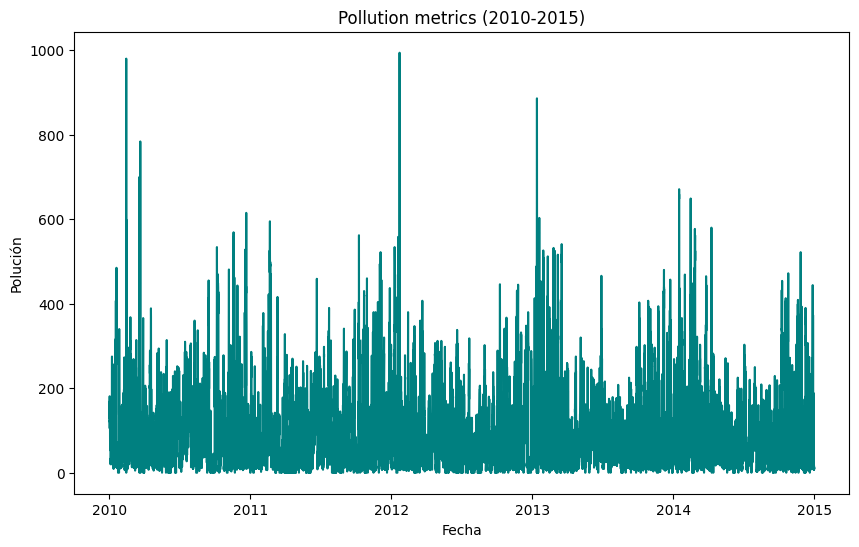

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(raw_df.index, raw_df['pollution'], label='Pollution', color = "teal")
plt.title('Pollution metrics (2010-2015)')
plt.xlabel('Fecha')
plt.ylabel('Polución')
plt.show()

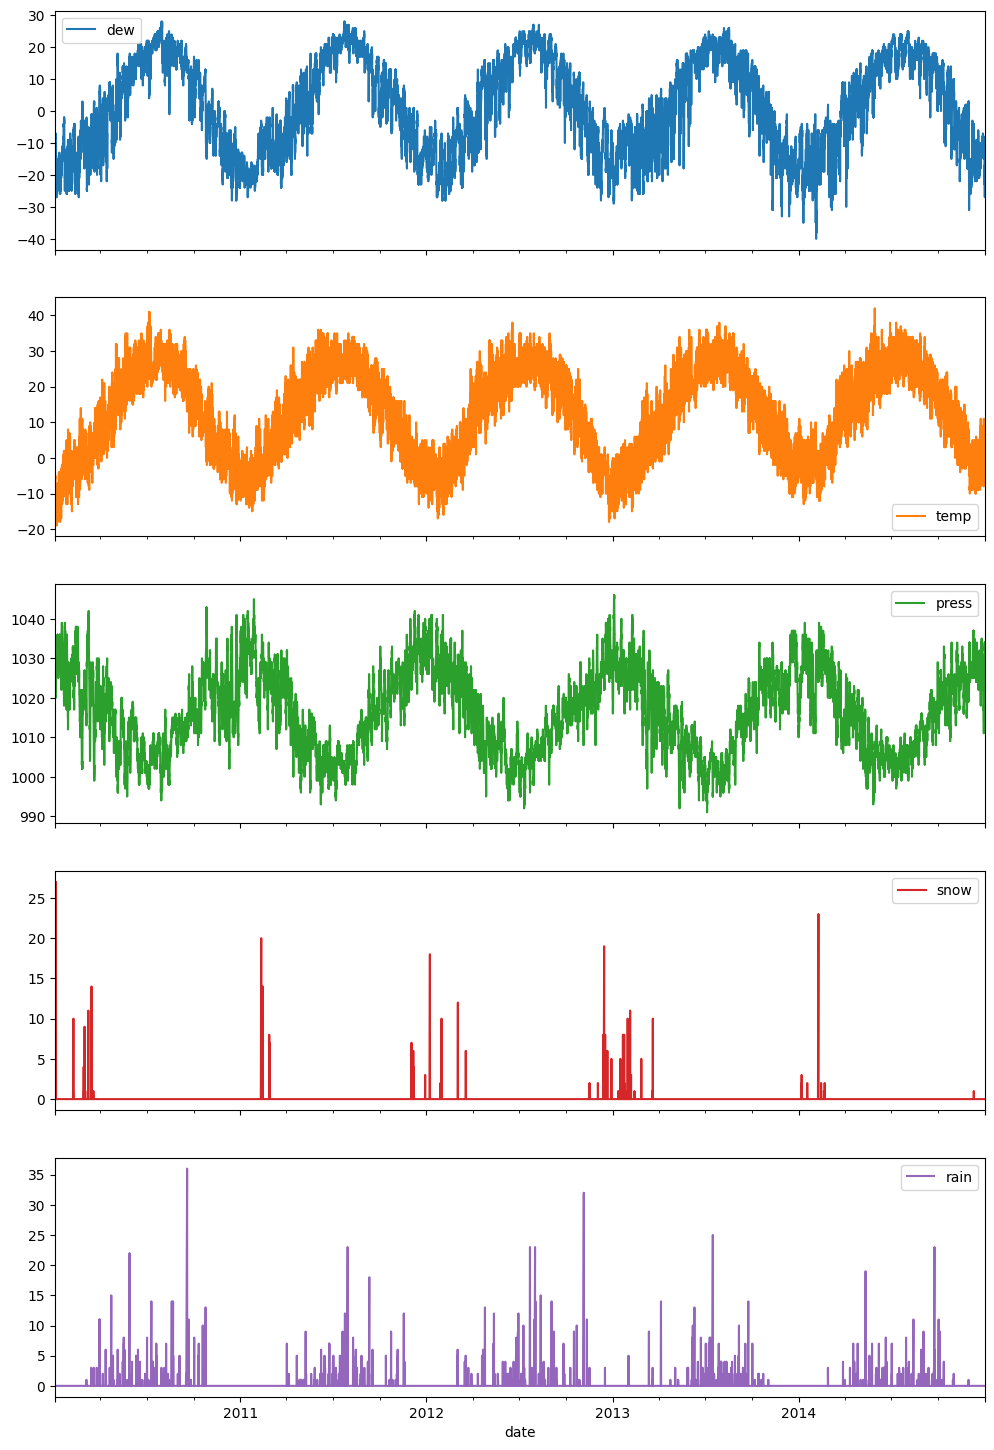

In [12]:
raw_df[['dew', 'temp', 'press', 'wnd_dir', 'snow', 'rain']].plot(subplots=True, figsize=(12, 18))
plt.show()

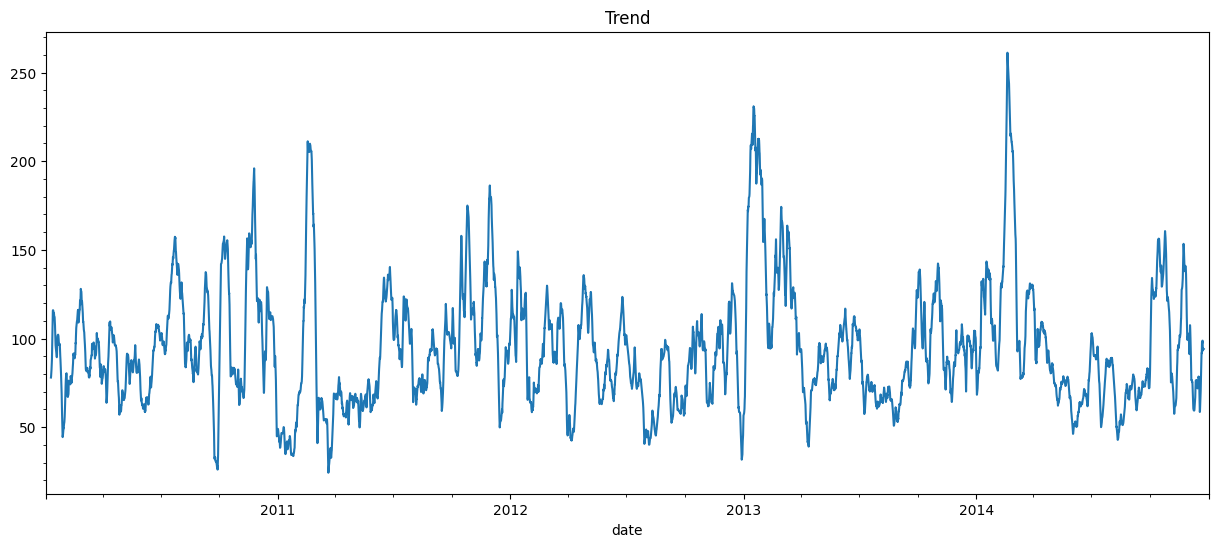

In [13]:
df = raw_df.copy()
df.pop("wnd_dir")
result = seasonal_decompose(df['pollution'], model='additive', period=365)
plt.figure(figsize=(15, 6))
plt.title("Trend")
plt.minorticks_on()
result.trend.plot()
plt.show()

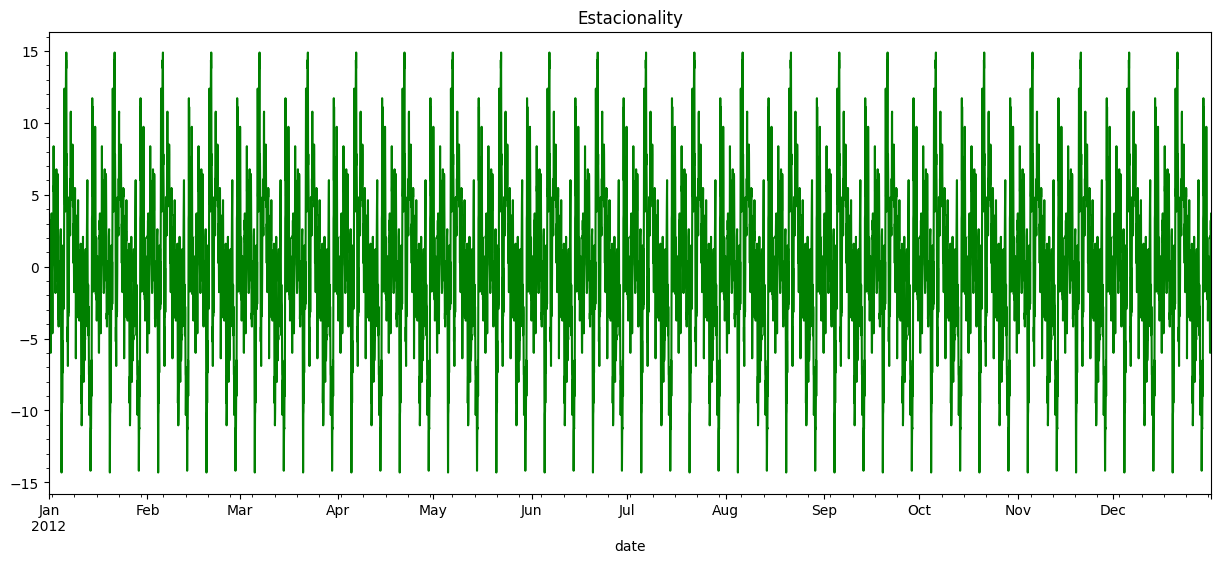

In [14]:
plt.figure(figsize=(15, 6))
plt.title("Estacionality")
plt.minorticks_on()
result.seasonal["2012"].plot(color="green")
plt.show()


After visualizing the target variable and the covariates, it's possible to identify patterns suggesting potential seasonality. Next, we will plot the autocorrelation and partial autocorrelation, which show how the time series correlates with a lagged version of itself, and apply the augmented Dickey-Fuller test at various significance levels.

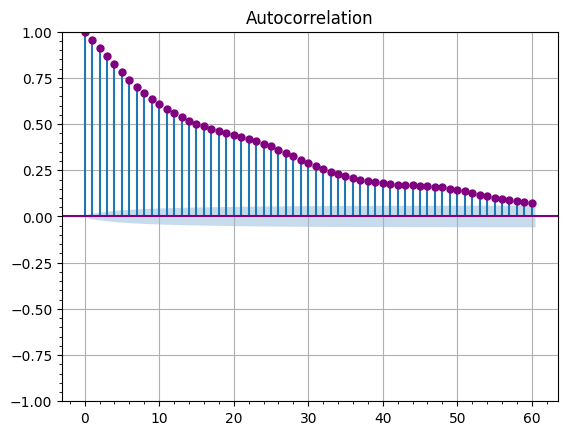

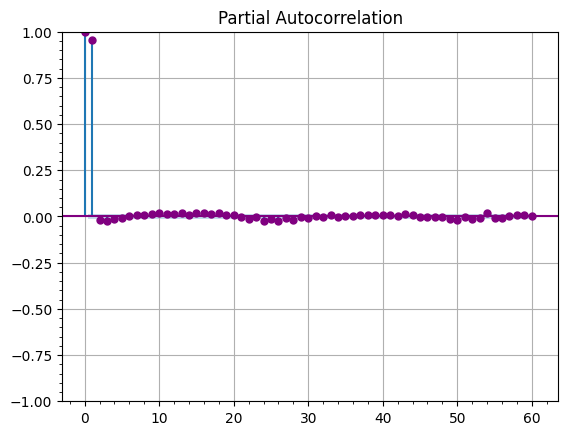

In [15]:
plot_acf(df['pollution'], lags=60, color="purple", alpha=0.01)
plt.grid()
plt.minorticks_on()
plt.show()
plot_pacf(df['pollution'], lags=60, color="purple", alpha =0.01)
plt.grid()
plt.minorticks_on()
plt.show()

In [16]:
#Comparing the seasonality of the data at different significance levels (1%, 5%, and 10%).
p_estacionalidad = sm.tsa.adfuller(raw_df['pollution'], maxlag=30, regression='c', autolag='AIC')
print('ADF Statc', p_estacionalidad[0])
print('p-valor:', p_estacionalidad[1])
print('Valor crítico:', p_estacionalidad[4])

ADF Statc -24.747770597744832
p-valor: 0.0
Valor crítico: {'1%': -3.4304994101792583, '5%': -2.8616060360236197, '10%': -2.5668051488274246}


Upon comparing the statistic and critical values for different significance levels, along with their respective p-values of the  augmented Dickey-Fuller test , it is concluded that the series exhibits seasonality.

#**Dataset segmentation**
In the second section, data segmentation is performed, the array is reorganized to be presented to the deep learning network, and values are scaled to a homogeneous range to prevent measurement scale bias during model training. Additionally, some visualizations are conducted.

In [17]:
#Data Splitting
tr_len = int(len(df)*0.8)
tst_len = int(len(df)*0.1)
val_len = df.shape[0] - tr_len - tst_len
print(tr_len, tst_len, val_len)


35040 4380 4380


In [18]:
tr_df = df[0:tr_len]
val_df =df[tr_len: tr_len+val_len]
tst_df = df[tr_len+val_len:]
print(f"traning dataset shape:{tr_df.shape}")
print(f"validation dataset shape:{val_df.shape}")
print(f"testing dataset shape:{tst_df.shape}")

traning dataset shape:(35040, 7)
validation dataset shape:(4380, 7)
testing dataset shape:(4380, 7)


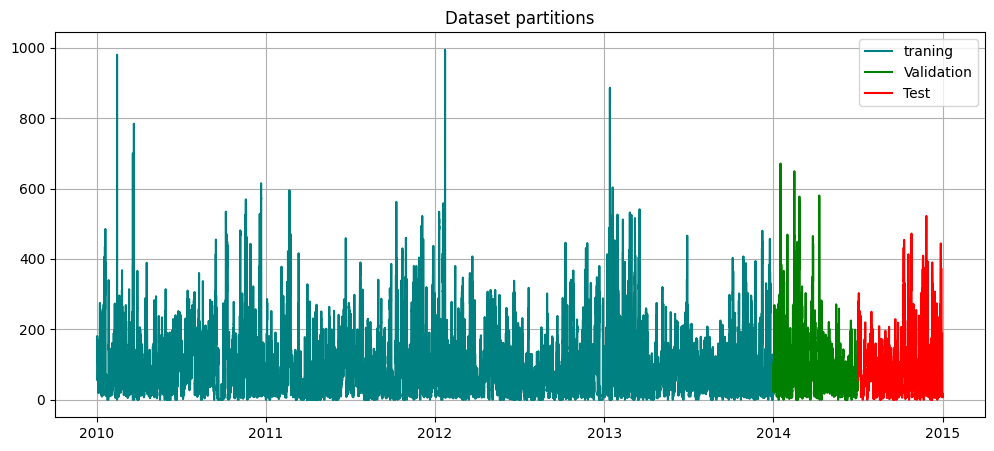

In [19]:
fig, ax = plt.subplots(figsize = (12 ,5))
ax.plot(tr_df["pollution"], label = "traning", color= "teal")
ax.plot(val_df["pollution"], label = "Validation", color= "green")
ax.plot(tst_df["pollution"], label = "Test", color="red")
plt.title("Dataset partitions")
plt.legend()
plt.grid()
plt.show()

In [20]:
#This function is designed to apply univariate models
#This function reshapes
def ventana_paquetes_datos(array, tamaño_paquete_entrada, tamaño_paquete_salida):
    X, Y = [], []
    shape = array.shape

    if len(shape) == 1:
        filas, cols = array.shape[0], 1
    else:
        filas, cols = array.shape

    for i in range(filas - tamaño_paquete_entrada - tamaño_paquete_salida):
        X.append(array[i:i+tamaño_paquete_entrada, 0:cols])
        #The following line selects the variable to predict. Be careful when selecting its column index.
        Y.append(array[i + tamaño_paquete_entrada: i + tamaño_paquete_entrada + tamaño_paquete_salida, 0].reshape(tamaño_paquete_salida,1))

    x = np.array(X)
    y = np.array(Y)
    return x, y

In [21]:
paquete_ent = 24
paquete_sal = 1

x_tr, y_tr = ventana_paquetes_datos(tr_df.values, paquete_ent, paquete_sal)
x_val, y_val = ventana_paquetes_datos(val_df.values, paquete_ent, paquete_sal)
x_ts, y_ts = ventana_paquetes_datos(tst_df.values, paquete_ent, paquete_sal)

In [22]:
#Verification of the dataset's dimensionality
print(f"traning subset- x_tr: {x_tr.shape}, y_tr: {y_tr.shape}")
print(f"validation subset - x_vl: {x_val.shape}, y_vl: {y_val.shape}")
print(f"test subset - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}")

traning subset- x_tr: (35015, 24, 7), y_tr: (35015, 1, 1)
validation subset - x_vl: (4355, 24, 7), y_vl: (4355, 1, 1)
test subset - x_ts: (4355, 24, 7), y_ts: (4355, 1, 1)


In [23]:
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_val, 'y_vl': y_val,
    'x_ts': x_ts, 'y_ts': y_ts,
}

In [24]:
print(f"shape of x_tr_s: {data_in['x_tr'].shape}")
print(f"shape of y_tr_s: {data_in['y_ts'].shape}")

shape of x_tr_s: (35015, 24, 7)
shape of y_tr_s: (4355, 1, 1)


In [25]:
#Development of the scaling function
def escalar_dataset(data_input, col_ref):
    num_características = data_input['x_tr'].shape[2]
    col_ref = df.columns.get_loc(col_ref)

    # Generate a list of "scalers"
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(num_características)]

    # Arrays that will contain the scaled datasets.
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Scaling: the min/max of the training set will be used to scale the entire dataset

    # scaling Xs
    for i in range(num_características):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i])
        x_vl_s[:,:,i] = scalers[i].transform(x_val[:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])

    # scaling Ys
    y_tr_s[:,:,0] = scalers[col_ref].fit_transform(y_tr[:,:,0])
    y_vl_s[:,:,0] = scalers[col_ref].transform(y_val[:,:,0])
    y_ts_s[:,:,0] = scalers[col_ref].transform(y_ts[:,:,0])

    # Developing axit arrays
    data_scal = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scal, scalers[col_ref]

In [26]:
#Executing scaling function
data_s, scaler = escalar_dataset(data_in, col_ref="pollution")

In [27]:
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

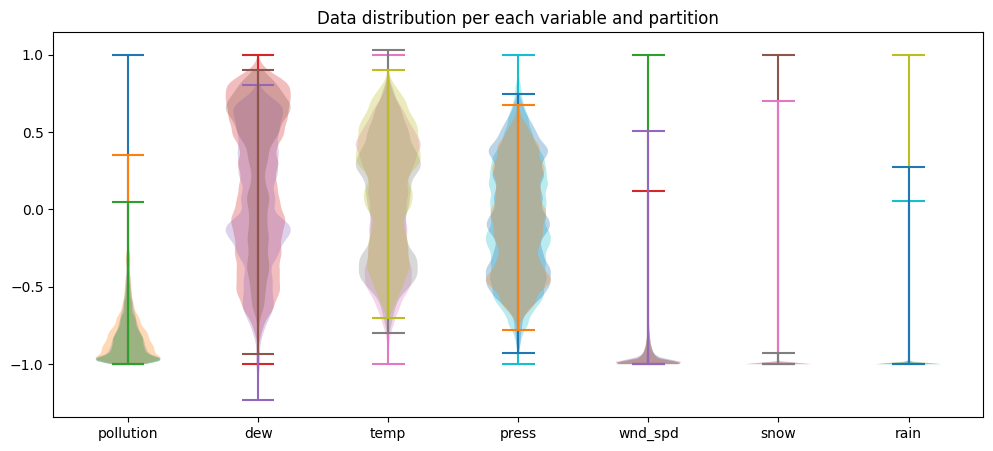

In [28]:
#Visualization of the distributions of the variables
labels = ['pollution','dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain']
positions = np.arange(len(labels))

fig, ax = plt.subplots(figsize = (12 ,5))
for i in range(data_in['x_tr'].shape[2]):
  ax.violinplot(x_tr_s[:,:,i].flatten(), positions = [i])
  ax.violinplot(x_vl_s[:,:,i].flatten(), positions = [i])
  ax.violinplot(x_ts_s[:,:,i].flatten(), positions = [i])

ax.set_xticks(positions)
plt.title("Data distribution per each variable and partition")
ax.set_xticklabels(labels)
ax.autoscale()
plt.show()

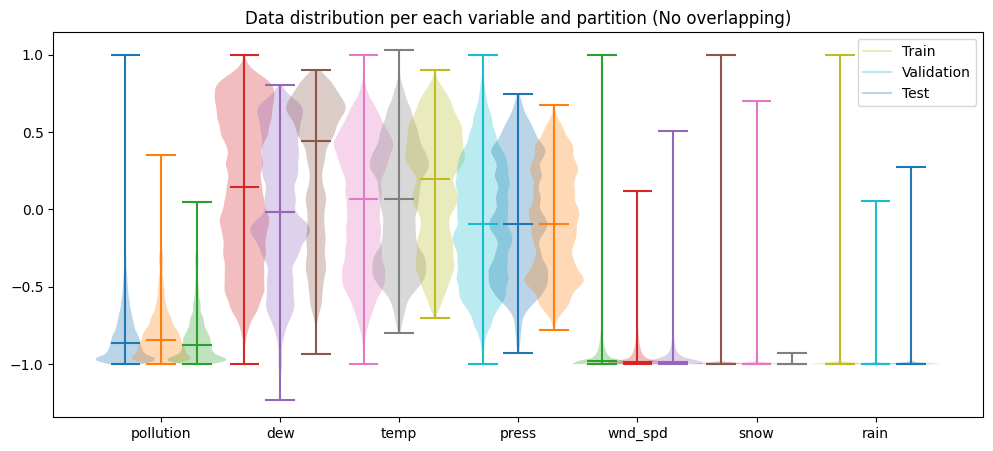

In [29]:
labels = ['pollution','dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain']
positions = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(12, 5))

for i in range(len(labels)):
    parts_tr = ax.violinplot(x_tr_s[:, :, i].flatten(), positions=[positions[i] - 0.3], showmeans=False, showmedians=True)
    parts_vl = ax.violinplot(x_vl_s[:, :, i].flatten(), positions=[positions[i]], showmeans=False, showmedians=True)
    parts_ts = ax.violinplot(x_ts_s[:, :, i].flatten(), positions=[positions[i] + 0.3], showmeans=False, showmedians=True)

# columns labels
ax.set_xticks(positions)
ax.set_xticklabels(labels)

# adding legend
legend_labels = ['Train', 'Validation', 'Test']
legend_colors = [parts_tr['bodies'][0].get_facecolor().flatten(),
                 parts_vl['bodies'][0].get_facecolor().flatten(),
                 parts_ts['bodies'][0].get_facecolor().flatten()]

custom_lines = [plt.Line2D([0], [0], color=color) for color in legend_colors]
ax.legend(custom_lines, legend_labels)
plt.title("Data distribution per each variable and partition (No overlapping)")
plt.show()

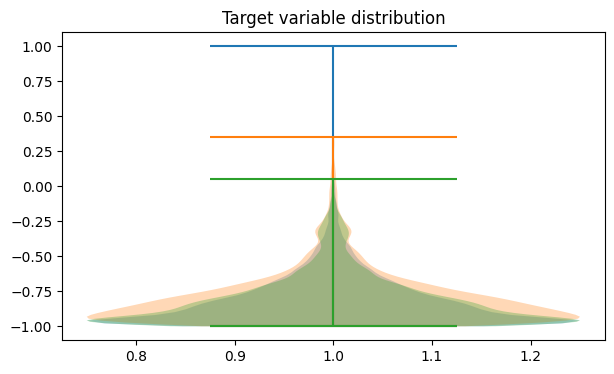

In [30]:
fig, ax = plt.subplots(figsize = (7 ,4))
ax.violinplot(y_tr_s[:,:,0].flatten())
ax.violinplot(y_vl_s[:,:,0].flatten())
ax.violinplot(y_ts_s[:,:,0].flatten())

ax.autoscale()
plt.title("Target variable distribution")
plt.show()

In [31]:
#Seed and determinism for reproductibility
tf.random.set_seed(12896)
np.random.seed(12896)
tf.config.experimental.enable_op_determinism()

#**Model Development and Evaluation**

In the third section of the project, the network architecture is developed, trained, and validated using each corresponding dataset. Finally, predictions are made for the test set, and comparisons between predicted and actual values are visualized. The process also includes feature importance selection (PIF).

In [32]:
#Generating model
unds = 140
input = (x_tr_s.shape[1],x_tr_s.shape[2])
mod = Sequential()
mod.add(LSTM(units=unds, input_shape=input))
mod.add(Dense(paquete_sal, activation="linear"))

optim = RMSprop(learning_rate=0.00005)
mod.compile(optimizer=optim, loss=tf.keras.losses.MeanSquaredError())
mod.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 140)               82880     
                                                                 
 dense (Dense)               (None, 1)                 141       
                                                                 
Total params: 83021 (324.30 KB)
Trainable params: 83021 (324.30 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
#Model training
EPOCHS = 80
BATCH_SIZE = 256
historia = mod.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=1
)

Epoch 1/80
137/137 [==============================] - 5s 14ms/step - loss: 0.1259 - val_loss: 0.0192
Epoch 2/80
137/137 [==============================] - 1s 6ms/step - loss: 0.0141 - val_loss: 0.0120
Epoch 3/80
137/137 [==============================] - 1s 5ms/step - loss: 0.0114 - val_loss: 0.0103
Epoch 4/80
137/137 [==============================] - 1s 6ms/step - loss: 0.0100 - val_loss: 0.0091
Epoch 5/80
137/137 [==============================] - 1s 5ms/step - loss: 0.0091 - val_loss: 0.0086
Epoch 6/80
137/137 [==============================] - 1s 5ms/step - loss: 0.0085 - val_loss: 0.0077
Epoch 7/80
137/137 [==============================] - 1s 5ms/step - loss: 0.0080 - val_loss: 0.0074
Epoch 8/80
137/137 [==============================] - 1s 5ms/step - loss: 0.0076 - val_loss: 0.0070
Epoch 9/80
137/137 [==============================] - 1s 5ms/step - loss: 0.0072 - val_loss: 0.0067
Epoch 10/80
137/137 [==============================] - 1s 5ms/step - loss: 0.0069 - val_loss: 0.006

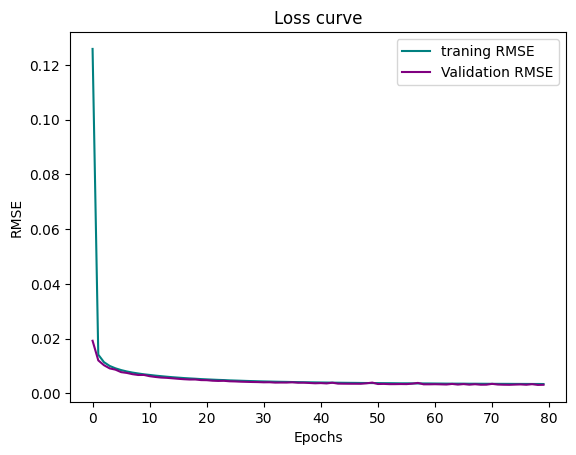

In [34]:
plt.plot(historia.history['loss'], label = "traning RMSE", color="teal")
plt.plot(historia.history['val_loss'], label = "Validation RMSE", color="purple")
plt.title("Loss curve")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()
plt.show()

In [35]:
RMSE_tr = mod.evaluate(x_tr_s, y_tr_s, verbose=0)
RMSE_vl = mod.evaluate(x_vl_s, y_vl_s, verbose=0)
RME_ts = mod.evaluate(x_ts_s, y_ts_s, verbose=0)
print(f"RMSE de entrenamiento: {RMSE_tr:.4f}")
print(f"RMSE de validación: {RMSE_vl:.4f}")
print(f"RMSE de test: {RME_ts:.4f}")

RMSE de entrenamiento: 0.0034
RMSE de validación: 0.0031
RMSE de test: 0.0023


In [36]:
def predecir(x, modelo, escalador):
    y_pred = modelo.predict(x)
    y_pred = y_pred.reshape(-1, 1)
    y_pr = escalador.inverse_transform(y_pred)
    y_pr = y_pr.flatten()
    return y_pr

In [37]:
y_ts_pred = predecir(x_ts_s, mod, scaler)
y_ts_pred.shape

137/137 [==============================] - 1s 2ms/step


(4355,)

In [38]:
print(y_ts_pred.max())
print(y_ts_pred.min())
print(y_ts.max())
print(y_ts.min())

484.38507
-7.7515836
522.0
0.0


In [39]:
y_ts_flat = y_ts.flatten()
error_pred =  y_ts_pred - y_ts_flat
error_pred.shape

(4355,)

In [40]:
errores = pd.DataFrame(data={"y_true":y_ts_flat, "y_pred":y_ts_pred})
errores.head()

,y_true,y_pred
0,256.0,262.679047
1,232.0,250.213898
2,212.0,230.874756
3,177.0,212.114655
4,175.0,183.474594


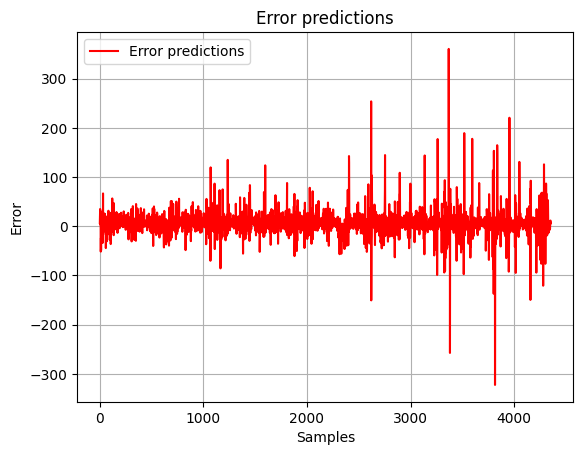

In [41]:
#Plotting the difference between predicted and actual values as a metric of error.
plt.plot(error_pred, label = "Error predictions", color = "red")
plt.title("Error predictions")
plt.xlabel("Samples")
plt.ylabel("Error")
plt.legend()
plt.grid()
plt.show()

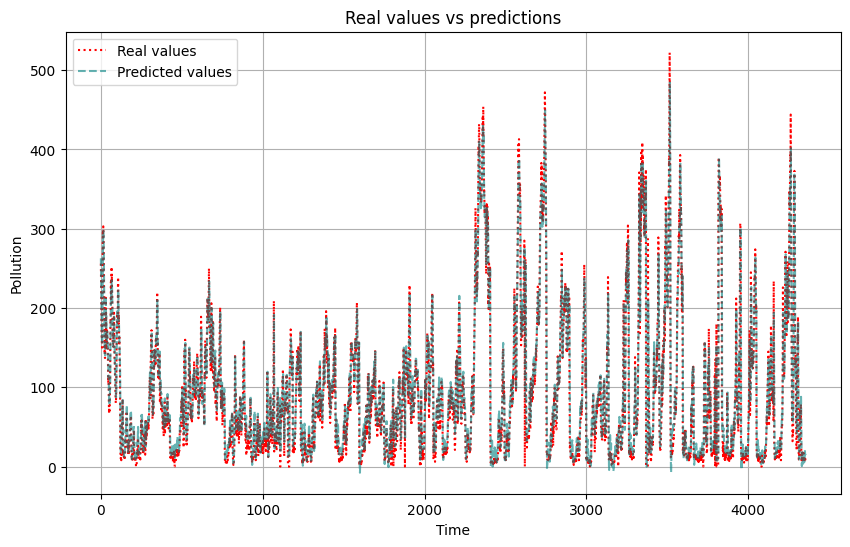

In [42]:
#Visualization of the predicted and actual series.
plt.figure(figsize=(10, 6))
plt.plot(errores["y_true"], label="Real values", color ="red", ls = ":")
plt.plot(errores["y_pred"], label= "Predicted values", color = "teal", ls = "--", alpha = 0.6)
plt.title("Real values vs predictions")
plt.xlabel("Time")
plt.ylabel("Pollution")
plt.legend()
plt.grid()
plt.show()

In [43]:
#Development of the function for visualizing feature importance.
def pfi_mod(modelo, x, y, cols):
  N_vars=x.shape[2]
  pfi_results=[]

  rmse= mod.evaluate(x, y, verbose=0)
  for i in range(N_vars):
    print(f"Permuting and calculating PFI for feature {i+1} of {N_vars}")
    col_original = x[:,:,i].copy()
    np.random.shuffle(x[:,:,i])
    rmse_perm = mod.evaluate(x, y, verbose=0)
    pfi_results.append({"Variable":cols[i],"PFI":rmse_perm/rmse})
    x[:,:,i] = col_original

  PFI_df= pd.DataFrame(pfi_results).sort_values(by="PFI", ascending=False)
  return PFI_df

In [44]:
PFI_df = pfi_mod(mod, x_ts_s, y_ts_s, df.columns)
PFI_df

Permuting and calculating PFI for feature 1 of 7
Permuting and calculating PFI for feature 2 of 7
Permuting and calculating PFI for feature 3 of 7
Permuting and calculating PFI for feature 4 of 7
Permuting and calculating PFI for feature 5 of 7
Permuting and calculating PFI for feature 6 of 7
Permuting and calculating PFI for feature 7 of 7


,Variable,PFI
0,pollution,24.964576
1,dew,1.131840
2,temp,1.118349
3,press,1.010437
6,rain,1.007682
4,wnd_spd,1.004383
5,snow,0.999993


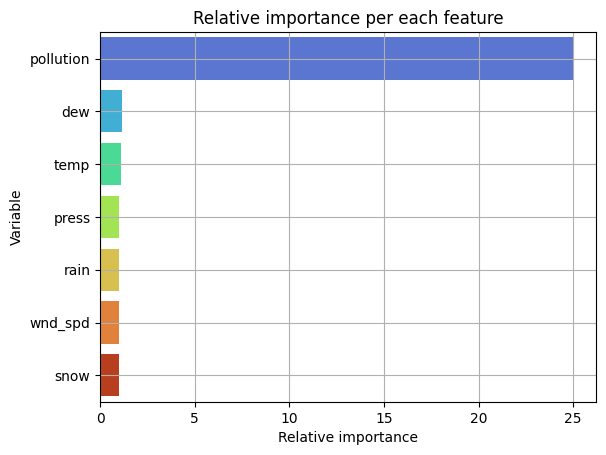

In [46]:
ax = sns.barplot(x="PFI", y="Variable", data = PFI_df , palette="turbo")
ax.set_xlabel("Relative importance")
plt.title("Relative importance per each feature")
plt.grid()
plt.show()



#**Interpretation of Results**

The results from Permuted Feature Importances (PFI) indicate the importance of each variable in the pollution prediction model. PFI measures how much the model's accuracy degrades when the values of a feature are randomly permuted, breaking the relationship between the feature and the target.

**pollution (25.721779):**

This variable has the highest PFI value with a significant difference compared to other variables. The high score suggests that this variable is extremely important for the model. Permuting its values drastically affects the model's accuracy, indicating that past pollution is a crucial predictor for future pollution.

**temp (1.144160):**

Temperature is the second most important variable, although its PFI is much lower than pollution. This indicates that while temperature is relevant, its impact on the model's accuracy is moderate.

**dew (1.135107):**

Dew point has a similar importance to temperature. This suggests that air humidity also plays a role in pollution prediction, though less crucially than temperature and far less than past pollution.

##**Conclusions and Potential Improvements**

Based on the Root Mean Squared Error (RMSE) values provided, your LSTM model has shown outstanding performance in time series pollution prediction, with very low RMSEs for training, validation, and test sets, indicating high accuracy and model generalization.

The permuted feature importances suggest that 'pollution' is by far the most influential feature, which is expected since it's likely the target variable being predicted. Other features like 'temp', 'dew', 'press', 'rain', 'wnd_spd', and 'snow' have significantly lower importance scores but still contribute to the model's predictions.

##**Observations:**

The close values of RMSE among training, validation, and test sets suggest that your model is not overfitting and generalizes well to unseen data. The dominance of 'pollution' in feature importance could indicate that the model heavily relies on past pollution values to make predictions.

In conclusion, it's feasible to create a univariate unistep or multistep model given that the response variable contributes almost all predictive power to the model, optimizing simplicity in code and substantially reducing computational requirements.

##**Further Analysis:**

**Cross-Validation:** To ensure the robustness of your model, consider performing k-fold cross-validation.

**Feature Engineering:** Experiment with additional features or transformations that could capture more complex patterns in the data.

**Hyperparameter Tuning:** Optimize LSTM hyperparameters to potentially improve model performance.

**Model Interpretability:** Use techniques like SHAP (SHapley Additive exPlanations) to gain a deeper understanding of feature contributions.

**External Factors:** Investigate whether external factors not included in the dataset could enhance model predictions.

These steps can help enhance the model's performance, robustness, and interpretability, providing deeper insights into pollution dynamics and improving its predictive capabilities.